In [ ]:
!pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa
import librosa.display
from google.colab import drive
from google.colab import files
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation,Flatten,InputLayer,Dropout,TimeDistributed,BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
from glob import glob
import soundfile as sf
from keras.callbacks import ModelCheckpoint
from datetime import datetime
import keras
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import time

In [3]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


# Data set creation

In [4]:
subdir = "gdrive/My Drive/Deep learning/data set progetto/audio"
classified_data = pd.read_csv(os.path.join('gdrive/My Drive/Deep learning/data set progetto/', 'data.csv'))
our_data=glob("gdrive/My Drive/Deep learning/data set progetto/audio/*.wav")
our_data2=glob("gdrive/My Drive/Deep learning/data set progetto/Audio2/*.wav")
our_data3=glob("gdrive/My Drive/Deep learning/data set progetto/audio4/*.wav")
subdir2 = "gdrive/My Drive/Deep learning/data set progetto/Audio2"
subdir3 = "gdrive/My Drive/Deep learning/data set progetto/audio4"


nome_file=[]
label=[]
for i in our_data:
  for j in classified_data['nome_file']:
    if i==os.path.join(subdir, j):
      nome_file.append(i[54:])
      label.append(list(classified_data[classified_data['nome_file']==j]['label'])[0])


for i in our_data2:
  for j in classified_data['nome_file']:
    if i==os.path.join(subdir2, j):
      nome_file.append(i[55:])
      label.append(list(classified_data[classified_data['nome_file']==j]['label'])[0])

for i in our_data3:
  for j in classified_data['nome_file']:
    if i==os.path.join(subdir3, j):
      nome_file.append(i[55:])
      label.append(list(classified_data[classified_data['nome_file']==j]['label'])[0])

data={'nome_file':nome_file, 'label':label}
df = pd.DataFrame(data)
print(df)

             nome_file          label
0      a149_90_100.wav           tram
1     b098_220_230.wav    city_center
2       b015_10_20.wav           park
3       a147_20_30.wav           tram
4       b112_10_20.wav            bus
...                ...            ...
1399    a023_40_50.wav          beach
1400  b106_140_150.wav  grocery_store
1401    b055_20_30.wav            car
1402  a110_120_130.wav  grocery_store
1403    a139_70_80.wav            car

[1404 rows x 2 columns]


# Balanced classes? --> Yes

In [ ]:
diz={}
for i in df.iterrows():
  if i[1][1] not in diz:
    diz[i[1][1]]=1
  else:
    diz[i[1][1]]+=1

total_observations = len(df)
percentages = {}
for category, count in diz.items():
  if category not in percentages:
    percentages[category]=(count / total_observations) * 100

for category, percentage in percentages.items():
    category= "\033[1m" + category + "\033[0m"
    print(f"The percentage of the label {category} in relation to the total number of observation is --> {round(percentage,2)}")


The percentage of the label tram in relation to the total number of observation is --> 6.48
The percentage of the label city_center in relation to the total number of observation is --> 7.48
The percentage of the label park in relation to the total number of observation is --> 5.98
The percentage of the label bus in relation to the total number of observation is --> 6.55
The percentage of the label car in relation to the total number of observation is --> 6.77
The percentage of the label grocery_store in relation to the total number of observation is --> 7.19
The percentage of the label forest_path in relation to the total number of observation is --> 7.05
The percentage of the label office in relation to the total number of observation is --> 6.41
The percentage of the label beach in relation to the total number of observation is --> 7.69
The percentage of the label library in relation to the total number of observation is --> 7.26
The percentage of the label cafe/restaurant in relati

# Is it worth increasing the audio by a few semitones?
No, calculating the same steps, the outputs are still the same or even worse.

In [ ]:
file_name = '/content/gdrive/MyDrive/Deep learning/data set progetto/audio/a001_160_170.wav'
ipd.Audio(file_name)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
audio_data,sample_rate = librosa.load(file_name)
audio_pitch_shifted = librosa.effects.pitch_shift(audio_data, sr=sample_rate, n_steps=0.3)
ipd.Audio(audio_pitch_shifted, rate=sample_rate)

# Is it worth scale between 0 and 1 the mfcc features?
No, calculating the same steps, the outputs are still the same or even worse.

In [ ]:
audio_data,sample_rate = librosa.load(file_name)
mfccs_features = librosa.feature.mfcc(y=audio_pitch_shifted, sr=sample_rate, n_mfcc=20)
print(mfccs_features)
def scale(values):
    min_val = np.min(values)
    max_val = np.max(values)
    scaled_values = [((x - min_val) )/ (max_val - min_val) for x in values]
    return scaled_values
print(scale(mfccs_features))

# Feature Extraction functions

In [5]:
def MFCC_matrix(row, dir_path, extracted_features):
  file_name = os.path.join(dir_path, str(row["nome_file"]))
  final_class_labels = row["label"]

  audio_data,sample_rate = librosa.load(file_name)
  mfccs_features = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=20)

  extracted_features.append([mfccs_features, final_class_labels])
  return extracted_features



def MFCC_adjusted(row, dir_path, extracted_features):
  file_name = os.path.join(dir_path, str(row["nome_file"]))
  final_class_labels = row["label"]

  audio_data,sample_rate = librosa.load(file_name)
  mfccs_features = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40)
  mfccs_features = np.mean(mfccs_features, axis=1)

  extracted_features.append([mfccs_features, final_class_labels])
  return extracted_features

# MFCC Analysis

In [23]:
#mfcc
dir = 'gdrive/My Drive/Deep learning/data set progetto/audio/'
dir2 = 'gdrive/My Drive/Deep learning/data set progetto/Audio2/'
dir3 = "gdrive/My Drive/Deep learning/data set progetto/audio4/"

extracted_features = []
count = 0
for index_num, row in tqdm(df.iterrows()):
    if count <= 467:
        dir_path = dir
    elif count <= 935:
        dir_path = dir2
    else:
        dir_path = dir3

    extracted_features = MFCC_matrix(row, dir_path, extracted_features)
    count += 1


1404it [02:20, 10.02it/s]


In [24]:
### converting extracted_features to Pandas dataframe
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])

### Split the dataset into train and test dataset
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())

#label to categorical
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

# train/test split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=0)

In [25]:
# mfcc
model = Sequential()


model.add(Dense(125, input_shape=(20,431)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.4))
model.add(BatchNormalization())

model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Dense(125))
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Flatten())


model.add(Dense(15, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 20, 125)           54000     
                                                                 
 activation_10 (Activation)  (None, 20, 125)           0         
                                                                 
 dropout_10 (Dropout)        (None, 20, 125)           0         
                                                                 
 batch_normalization_9 (Batc  (None, 20, 125)          500       
 hNormalization)                                                 
                                                                 
 dense_13 (Dense)            (None, 20, 256)           32256     
                                                                 
 activation_11 (Activation)  (None, 20, 256)           0         
                                                      

In [26]:
learning_rate=0.001
optimizer=keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer=optimizer)

In [27]:
import time
num_epochs = 25
num_batch_size = 16

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5',verbose=1, save_best_only=True)
start = time.time()

history=model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)

end = time.time()
time = end - start

print("Training completed in time: ", time)

Epoch 1/25
62/62 [==============================] - ETA: 0s - loss: 3.1282 - accuracy: 0.0876
Epoch 1: val_loss improved from inf to 2.70078, saving model to saved_models/audio_classification.hdf5
62/62 [==============================] - 6s 46ms/step - loss: 3.1282 - accuracy: 0.0876 - val_loss: 2.7008 - val_accuracy: 0.1848
Epoch 2/25
61/62 [============================>.] - ETA: 0s - loss: 2.3099 - accuracy: 0.2582
Epoch 2: val_loss improved from 2.70078 to 2.37166, saving model to saved_models/audio_classification.hdf5
62/62 [==============================] - 2s 40ms/step - loss: 2.3073 - accuracy: 0.2576 - val_loss: 2.3717 - val_accuracy: 0.2725
Epoch 3/25
62/62 [==============================] - ETA: 0s - loss: 1.7340 - accuracy: 0.4297
Epoch 3: val_loss improved from 2.37166 to 1.72582, saving model to saved_models/audio_classification.hdf5
62/62 [==============================] - 3s 42ms/step - loss: 1.7340 - accuracy: 0.4297 - val_loss: 1.7258 - val_accuracy: 0.4716
Epoch 4/25


In [ ]:
save_path = '/content/gdrive/MyDrive/Deep learning/model_MFCC_matrix'
model.save(save_path)

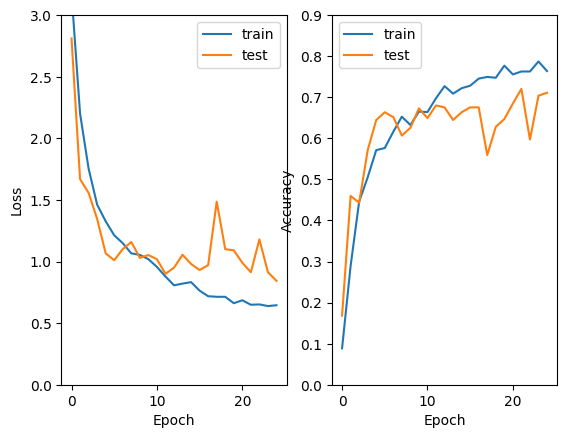

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim([0.0, 3.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'])

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim([0.0, 0.9])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'])

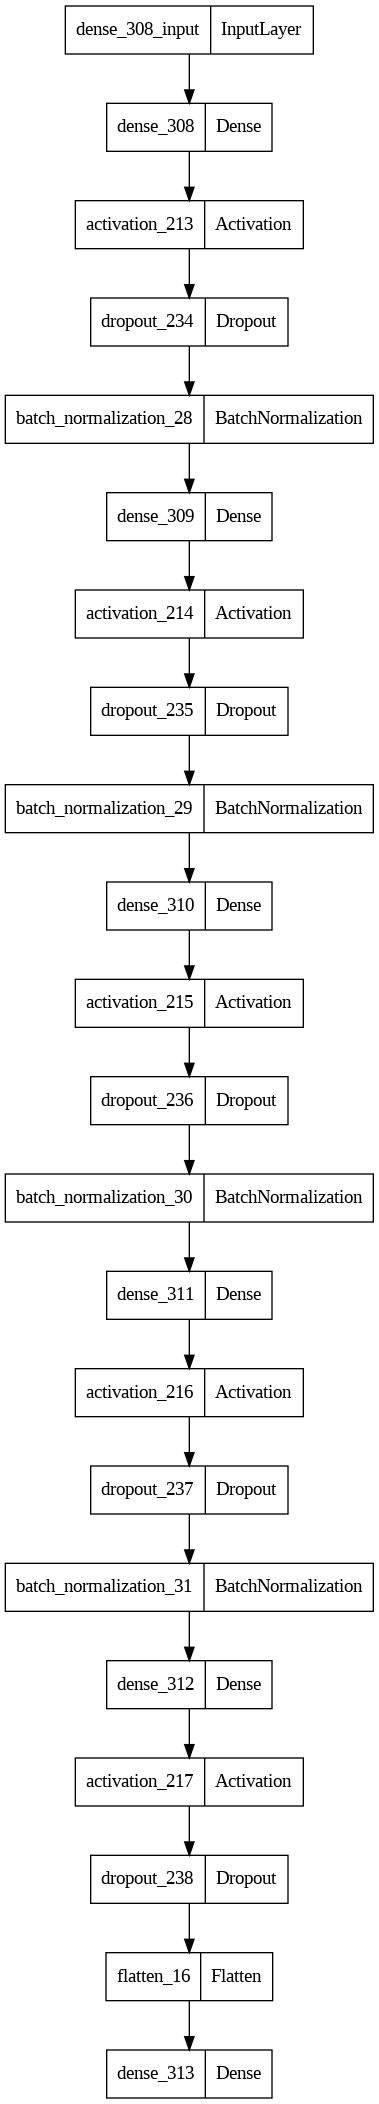

In [ ]:
keras.utils.plot_model(model, to_file='model.png')

# Adjusted MFCC analysis

In [12]:
dir = 'gdrive/My Drive/Deep learning/data set progetto/audio/'
dir2 = 'gdrive/My Drive/Deep learning/data set progetto/Audio2/'
dir3 = "gdrive/My Drive/Deep learning/data set progetto/audio4/"

extracted_features = []
count = 0
for index_num, row in tqdm(df.iterrows()):
    if count <= 467:
        dir_path = dir
    elif count <= 935:
        dir_path = dir2
    else:
        dir_path = dir3

    extracted_features = MFCC_adjusted(row, dir_path, extracted_features)
    count += 1


1404it [02:18, 10.17it/s]


In [13]:
### converting extracted_features to Pandas dataframe
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])

### Split the dataset into independent and dependent dataset
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())

#label to categorical
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

# train/test split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=0)

In [14]:
model = Sequential()

# First dense layer
model.add(Dense(125, input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(BatchNormalization())

# Second dense layer
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.35))
model.add(BatchNormalization())

# Third dense layer
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.45))
model.add(BatchNormalization())

# Fourth dense layer
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.35))
model.add(BatchNormalization())

# Fifth dense layer
model.add(Dense(125))
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(BatchNormalization())


model.add(Dense(15, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 125)               5125      
                                                                 
 activation_5 (Activation)   (None, 125)               0         
                                                                 
 dropout_5 (Dropout)         (None, 125)               0         
                                                                 
 batch_normalization_4 (Batc  (None, 125)              500       
 hNormalization)                                                 
                                                                 
 dense_7 (Dense)             (None, 256)               32256     
                                                                 
 activation_6 (Activation)   (None, 256)               0         
                                                      

In [21]:
learning_rate=0.001
optimizer=keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer=optimizer)

In [22]:
import time
num_epochs = 120
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5',verbose=1, save_best_only=True)

start = time.time()
history=model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)
end = time.time()
time = end - start

print("Training completed in time: ", time)

Epoch 1/120
27/31 [=========================>....] - ETA: 0s - loss: 0.5193 - accuracy: 0.8125
Epoch 1: val_loss improved from inf to 0.65841, saving model to saved_models/audio_classification.hdf5
31/31 [==============================] - 3s 25ms/step - loss: 0.4971 - accuracy: 0.8177 - val_loss: 0.6584 - val_accuracy: 0.8318
Epoch 2/120
31/31 [==============================] - ETA: 0s - loss: 0.5235 - accuracy: 0.8269
Epoch 2: val_loss improved from 0.65841 to 0.59863, saving model to saved_models/audio_classification.hdf5
31/31 [==============================] - 1s 19ms/step - loss: 0.5235 - accuracy: 0.8269 - val_loss: 0.5986 - val_accuracy: 0.8389
Epoch 3/120
29/31 [===========================>..] - ETA: 0s - loss: 0.5240 - accuracy: 0.8297
Epoch 3: val_loss improved from 0.59863 to 0.54114, saving model to saved_models/audio_classification.hdf5
31/31 [==============================] - 1s 20ms/step - loss: 0.5217 - accuracy: 0.8310 - val_loss: 0.5411 - val_accuracy: 0.8436
Epoch 4/

In [ ]:
save_path = '/content/gdrive/MyDrive/Deep learning/model_MFCC_adjusted'
model.save(save_path)

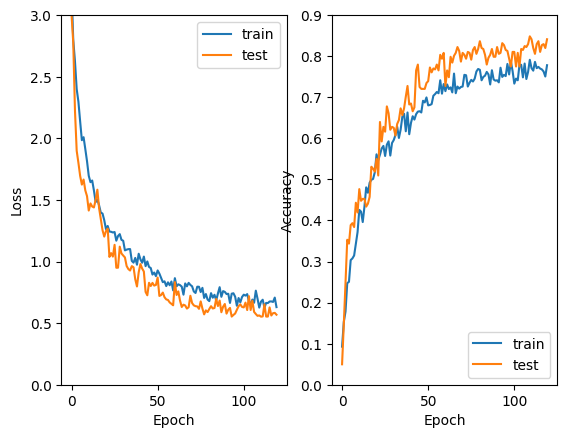

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim([0.0, 3.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'])

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim([0.0, 0.9])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'])

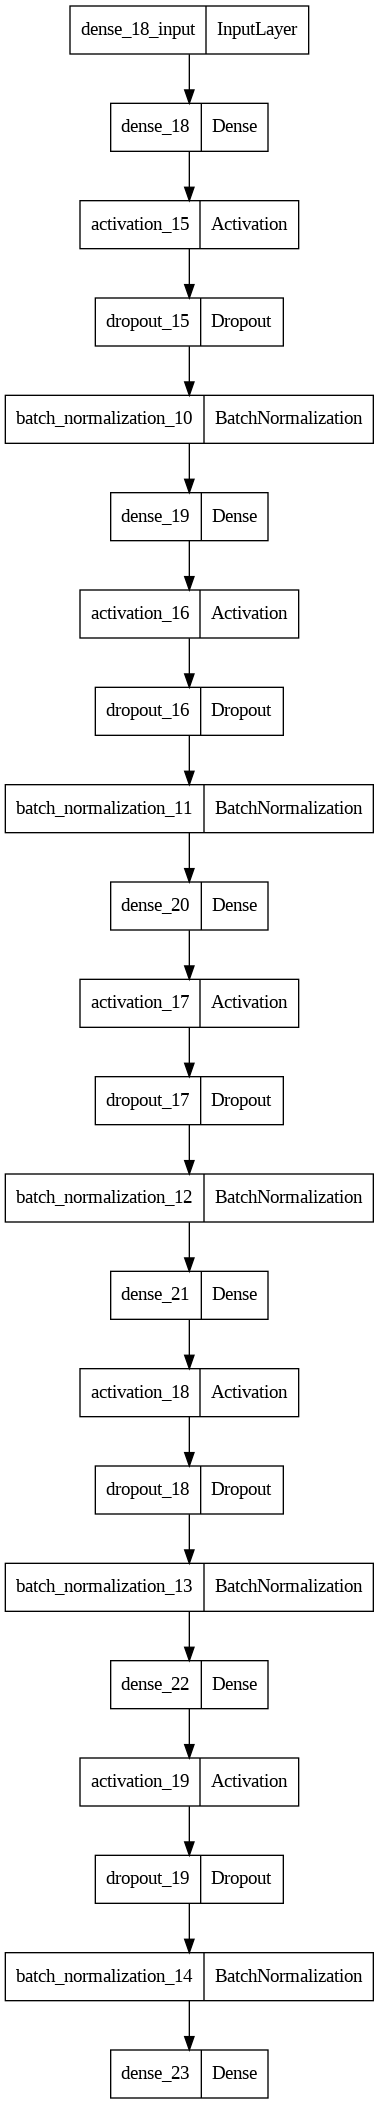

In [ ]:
keras.utils.plot_model(model, to_file='model.png')

# Analysis on the best MFCC model
The one with adjusted MFCC

In [ ]:
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

nome=[]
for i in X_test:
  c=0
  for j in X:
        c+=1
        if np.array_equal(i, j):
          nome.append(df['nome_file'][c-1])

# Stampa delle classificazioni
right=[]
wrong=[]
for i in range(len(X_test)):
  prediction_class = labelencoder.inverse_transform([predicted_classes[i]])
  real_class= labelencoder.inverse_transform([np.argmax(y_test[i])])
  nome_file=nome[i]
  if real_class[0]==prediction_class[0]:
    vero='Yes'
    right.append(nome_file)
  else:
    vero='No'
    wrong.append(nome_file)
  print("Nome file:", nome_file , "- Classe reale:", real_class[0], "- Classe predetta:", prediction_class[0], "- Right classification?:", vero)
print(f"The right classifcations are {len(right)}, so the percentage of right classifications is {len(right)/len(X_test)}")
print(f"While the wrong classifcations are {len(wrong)}, so the percentage of wrong classifications is {len(wrong)/len(X_test)}")

14/14 [==============================] - 0s 3ms/step
Nome file: a126_50_60.wav - Classe reale: cafe/restaurant - Classe predetta: metro_station - Right classification?: No
Nome file: b110_60_70.wav - Classe reale: bus - Classe predetta: bus - Right classification?: Yes
Nome file: a130_210_220.wav - Classe reale: cafe/restaurant - Classe predetta: cafe/restaurant - Right classification?: Yes
Nome file: a099_230_240.wav - Classe reale: office - Classe predetta: office - Right classification?: Yes
Nome file: a115_0_10.wav - Classe reale: grocery_store - Classe predetta: cafe/restaurant - Right classification?: No
Nome file: a087_150_160.wav - Classe reale: metro_station - Classe predetta: metro_station - Right classification?: Yes
Nome file: a041_65_75.wav - Classe reale: forest_path - Classe predetta: forest_path - Right classification?: Yes
Nome file: a063_70_80.wav - Classe reale: car - Classe predetta: car - Right classification?: Yes
Nome file: b021_10_20.wav - Classe reale: beach - 

# Testing neural network
Provided as input an audio file that can be classified into one of the labels on which the neural network has been trained, a correct classification will occur in about 84% of the cases.

In [ ]:
def prediction_on_new_data(file_path):
  audio, sample_rate = librosa.load(file_path)
  mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
  mfccs_features = np.mean(mfccs_features, axis=1)
  mfccs_features = np.array([mfccs_features])
  mfccs_features = np.reshape(mfccs_features, (1, 40))
  predictions = model.predict(mfccs_features)
  predicted_label = np.argmax(predictions, axis=-1)
  prediction_class = labelencoder.inverse_transform(predicted_label)
  for i in df.iterrows():
    if i[1][0]==file_path[62:]:
      real_label=i[1][1]
  return (f"The audio {file_path[62:]} with real label equal to {real_label} has been classified has {prediction_class[0]}")

In [ ]:
file_path = '/content/gdrive/MyDrive/Deep learning/data set progetto/audio/b098_220_230.wav'
print(prediction_on_new_data(file_path))
ipd.Audio(file_path)

Output hidden; open in https://colab.research.google.com to view.

# Transfer Learning

## **MODEL VGG**

In [ ]:
from keras.models import Model
from keras.layers import Dense
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 [==============================] - 1s 0us/step


In [ ]:
import keras
from keras.layers import Dropout

x = base_model.output

x = Dense(512, activation='relu')(x)

predictions = Dense(15, activation='softmax')(x)

In [ ]:
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Ridimensionamento e preelaborazione dei dati audio
from tensorflow.keras.applications.vgg16 import preprocess_input

X_train_resized = []
X_test_resized = []

for audio in X_train:
    audio_resized = cv2.resize(audio, (224, 224))
    audio_resized = np.repeat(audio_resized[..., np.newaxis], 3, axis=-1)
    X_train_resized.append(audio_resized)

for audio in X_test:
    audio_resized = cv2.resize(audio, (224, 224))
    audio_resized = np.repeat(audio_resized[..., np.newaxis], 3, axis=-1)
    X_test_resized.append(audio_resized)

X_train_preprocessed = preprocess_input(np.array(X_train_resized))
X_test_preprocessed = preprocess_input(np.array(X_test_resized))

In [ ]:
import time
# Definizione del modello
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(15, activation='softmax'))

# Compilazione del modello
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

start = time.time()

history=model.fit(X_train_preprocessed, y_train, batch_size=32, epochs=80, validation_data=(X_test_preprocessed, y_test))

end = time.time()
time = end - start

print("Training completed in time: ", time)

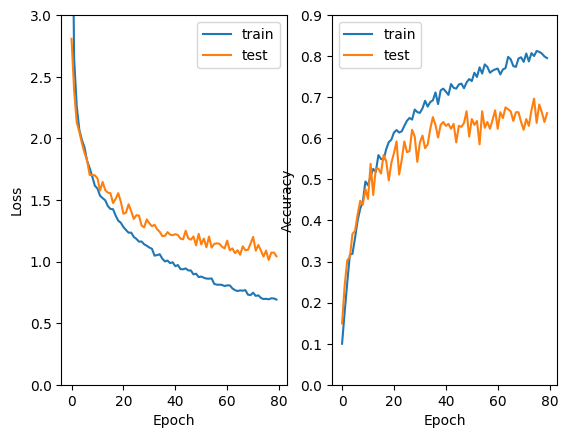

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim([0.0, 3.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'])

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim([0.0, 0.9])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'])

In [ ]:
model1 = Model(inputs=base_model.input, outputs=predictions)

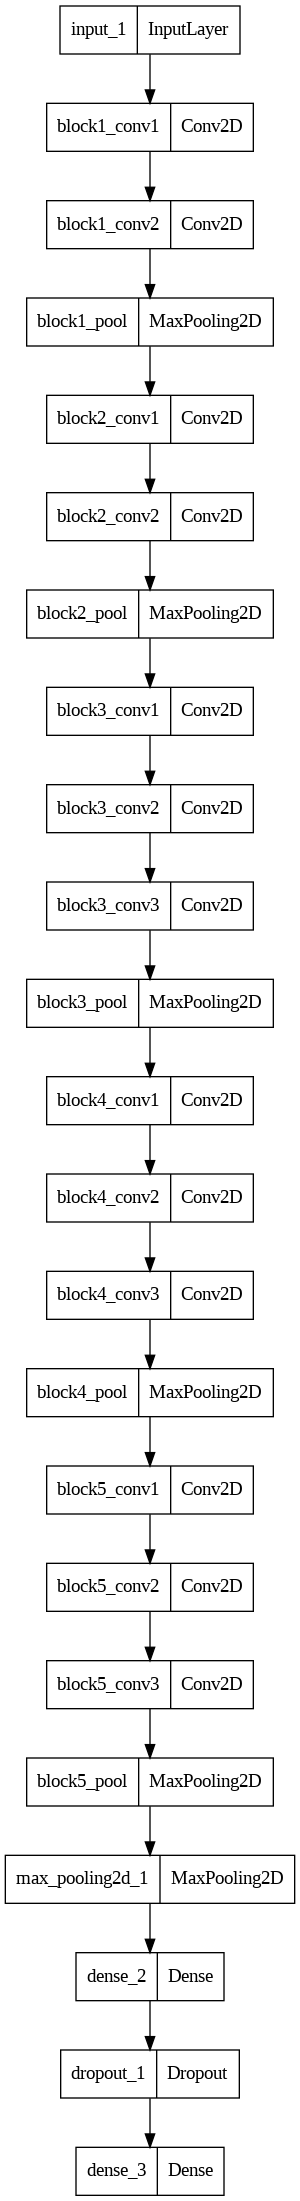

In [ ]:
keras.utils.plot_model(model1, to_file='model.png')

## **MODEL RESNET**

In [ ]:
from keras.models import Model
from keras.layers import Dense
from keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

94765736/94765736 [==============================] - 4s 0us/step


In [ ]:
import keras
from keras.layers import Dropout

x = base_model.output
x = Dense(512, activation='relu')(x)

predictions = Dense(15, activation='softmax')(x)

In [ ]:
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Ridimensionamento e preelaborazione dei dati audio
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

X_train_resized = []
X_test_resized = []

for audio in X_train:
    audio_resized = cv2.resize(audio, (224, 224))
    audio_resized = np.repeat(audio_resized[..., np.newaxis], 3, axis=-1)
    X_train_resized.append(audio_resized)

for audio in X_test:
    audio_resized = cv2.resize(audio, (224, 224))
    audio_resized = np.repeat(audio_resized[..., np.newaxis], 3, axis=-1)
    X_test_resized.append(audio_resized)

X_train_preprocessed = preprocess_input(np.array(X_train_resized))
X_test_preprocessed = preprocess_input(np.array(X_test_resized))

In [ ]:
import time
# Definizione del modello
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(15, activation='softmax'))

# Compilazione del modello
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Addestramento del modello utilizzando i dati preelaborati
start = time.time()

history=model.fit(X_train_preprocessed, y_train, batch_size=32, epochs=80, validation_data=(X_test_preprocessed, y_test))

end = time.time()
time = end - start

print("Training completed in time: ", time)

Epoch 1/80
31/31 [==============================] - 9s 192ms/step - loss: 2.6392 - accuracy: 0.1609 - val_loss: 2.3315 - val_accuracy: 0.2014
Epoch 2/80
31/31 [==============================] - 4s 144ms/step - loss: 2.1498 - accuracy: 0.3086 - val_loss: 2.0790 - val_accuracy: 0.3626
Epoch 3/80
31/31 [==============================] - 4s 138ms/step - loss: 1.9945 - accuracy: 0.3523 - val_loss: 2.0643 - val_accuracy: 0.3436
Epoch 4/80
31/31 [==============================] - 4s 137ms/step - loss: 1.8715 - accuracy: 0.4094 - val_loss: 1.8813 - val_accuracy: 0.4005
Epoch 5/80
31/31 [==============================] - 4s 141ms/step - loss: 1.8047 - accuracy: 0.4124 - val_loss: 1.7641 - val_accuracy: 0.4431
Epoch 6/80
31/31 [==============================] - 4s 138ms/step - loss: 1.7582 - accuracy: 0.4348 - val_loss: 1.7534 - val_accuracy: 0.4171
Epoch 7/80
31/31 [==============================] - 4s 141ms/step - loss: 1.6903 - accuracy: 0.4552 - val_loss: 1.7628 - val_accuracy: 0.4242
Epoch 

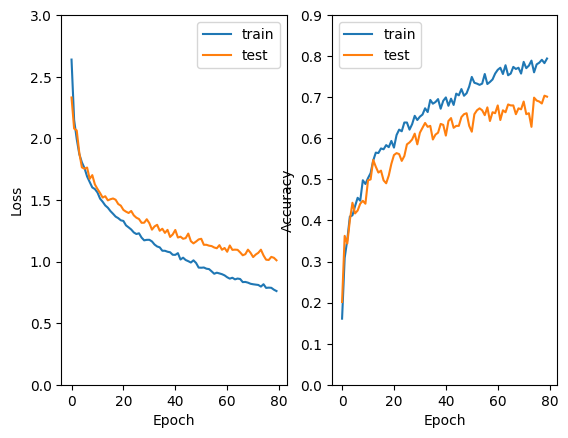

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim([0.0, 3.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'])

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim([0.0, 0.9])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'])

In [ ]:
model2 = Model(inputs=base_model.input, outputs=predictions)

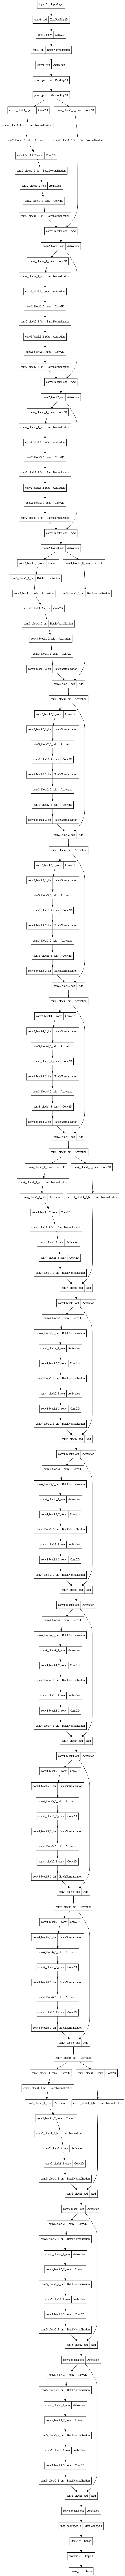

In [ ]:
keras.utils.plot_model(model2, to_file='model.png')

## **MobileNetV2**

In [ ]:
from keras.models import Model
from keras.layers import Dense
from keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import keras
import keras.utils
from keras import utils as np_utils

In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

9406464/9406464 [==============================] - 1s 0us/step


In [ ]:
import keras
from keras.layers import Dropout

x = base_model.output
x = Dense(512, activation='relu')(x)

predictions = Dense(15, activation='softmax')(x)

In [ ]:
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

X_train_resized = []
X_test_resized = []

for audio in X_train:
    audio_resized = cv2.resize(audio, (224, 224))
    audio_resized = np.repeat(audio_resized[..., np.newaxis], 3, axis=-1)
    X_train_resized.append(audio_resized)

for audio in X_test:
    audio_resized = cv2.resize(audio, (224, 224))
    audio_resized = np.repeat(audio_resized[..., np.newaxis], 3, axis=-1)
    X_test_resized.append(audio_resized)

X_train_preprocessed = preprocess_input(np.array(X_train_resized))
X_test_preprocessed = preprocess_input(np.array(X_test_resized))

In [ ]:
import time
# Definizione del modello
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(15, activation='softmax'))  # Cambio da 7 a 15 classi di output

# Compilazione del modello
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Addestramento del modello utilizzando i dati preelaborati
start = time.time()

history=model.fit(X_train_preprocessed, y_train, batch_size=32, epochs=80, validation_data=(X_test_preprocessed, y_test))

end = time.time()
time = end - start

print("Training completed in time: ", time)

Epoch 1/80
31/31 [==============================] - 9s 153ms/step - loss: 2.7253 - accuracy: 0.0978 - val_loss: 2.6754 - val_accuracy: 0.0853
Epoch 2/80
31/31 [==============================] - 2s 62ms/step - loss: 2.5003 - accuracy: 0.1660 - val_loss: 2.4551 - val_accuracy: 0.2299
Epoch 3/80
31/31 [==============================] - 2s 63ms/step - loss: 2.3695 - accuracy: 0.2189 - val_loss: 2.3813 - val_accuracy: 0.2322
Epoch 4/80
31/31 [==============================] - 2s 66ms/step - loss: 2.2625 - accuracy: 0.2566 - val_loss: 2.2944 - val_accuracy: 0.2536
Epoch 5/80
31/31 [==============================] - 2s 65ms/step - loss: 2.2090 - accuracy: 0.2637 - val_loss: 2.3046 - val_accuracy: 0.2583
Epoch 6/80
31/31 [==============================] - 2s 63ms/step - loss: 2.1924 - accuracy: 0.2566 - val_loss: 2.2095 - val_accuracy: 0.2986
Epoch 7/80
31/31 [==============================] - 2s 63ms/step - loss: 2.1587 - accuracy: 0.2862 - val_loss: 2.2424 - val_accuracy: 0.2962
Epoch 8/80
3

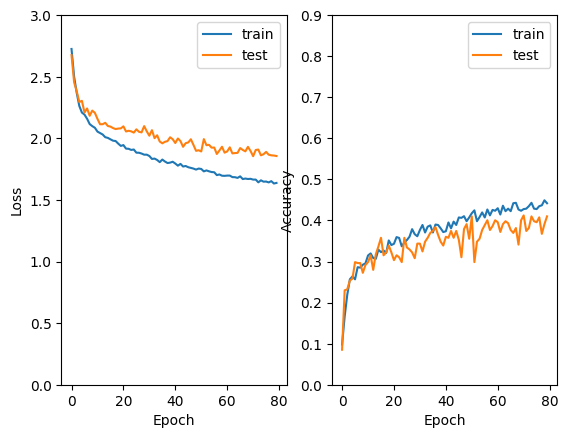

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim([0.0, 3.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'test'])

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim([0.0, 0.9])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'])

In [ ]:
model3 = Model(inputs=base_model.input, outputs=predictions)

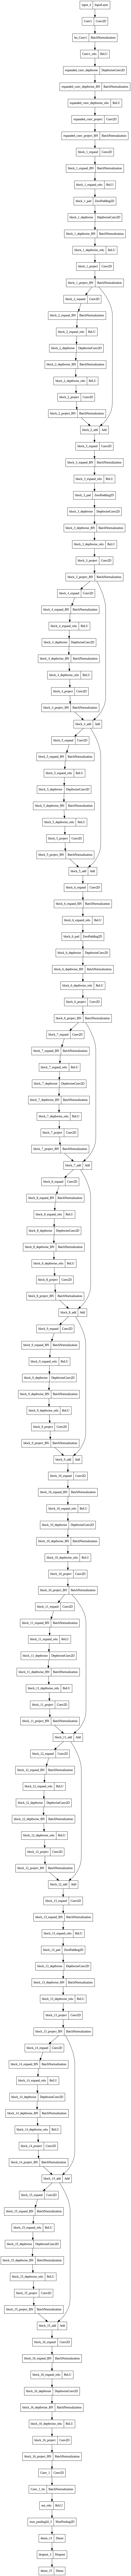

In [ ]:
keras.utils.plot_model(model3, to_file='model.png')